In [9]:
import sys,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,Activation,Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from datetime import datetime

In [5]:
df_Beijing=pd.read_csv('./FiveCitiesPM/Beijing.csv')
df_Beijing=df_Beijing[df_Beijing.year>=2015]
df_Beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0


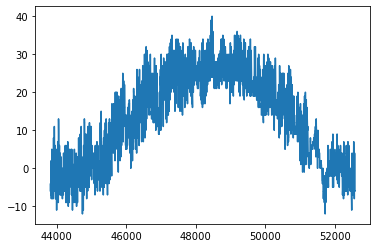

In [6]:
plt.plot(df_Beijing['TEMP'])

In [7]:
df_Beijing['PM_Dongsi']=df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['TEMP']=df_Beijing['TEMP'].interpolate()
df_Beijing['PM_Dongsi'].head()

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
Name: PM_Dongsi, dtype: float64

In [10]:
def make_date(row):
    return datetime(year=row['year'],month=row['month'],day=row['day'],hour=row['hour'])
df_Beijing['date']=df_Beijing.apply(make_date,axis=1)
df_Beijing.set_index(df_Beijing.date,inplace=True)

<AxesSubplot:xlabel='date'>

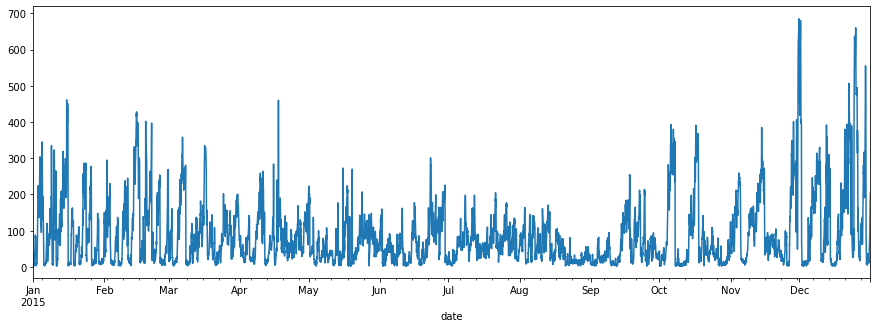

In [12]:
plt.figure(figsize=(15,5))
df_Beijing['PM_Dongsi'].plot()

In [15]:
def get_n_last_days(df,series_name,n_days):
    return df[series_name][-(24*n_days):]


def plot_n_last_days(df,series_name,n_days):
    plt.figure(figsize=(10,5))
    plt.plot(get_n_last_days(df,series_name,n_days),'k-')
    plt.title('{0} Air Quality Time Series - {1} days'.format(series_name,n_days))
    plt.xlabel('Recordedn Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

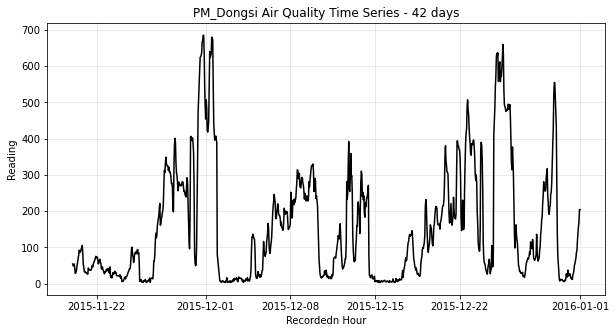

In [16]:
plot_n_last_days(df_Beijing,'PM_Dongsi',42)

In [24]:
def get_keras_format_series(series):
    series=np.array(series)
    return series.reshape(series.shape[0],series.shape[1],1)

def get_train_test_data(df,series_name,series_days,input_hours,test_hours,sample_gap=3):
    forecast_series=get_n_last_days(df,series_name,series_days).values
    
    train=forecast_series[:-test_hours]
    test=forecast_series[-test_hours:]
    
    train_X,train_y=[],[]
    
    for i in range(0,train.shape[0]-input_hours,sample_gap):
        train_X.append(train[i:i+input_hours])
        train_y.append(train[i+input_hours])
        
    train_X=get_keras_format_series(train_X)
    train_y=np.array(train_y)
    
    test_X_init=test[:input_hours]
    test_y=test[input_hours:]
    
    return train_X,test_X_init,train_y,test_y
                
    

In [25]:
series_days=56
input_hours=12
test_hours=24

train_X,test_X_init,train_y,test_y=(get_train_test_data(df_Beijing,'PM_Dongsi',series_days,input_hours,test_hours))


In [27]:
print('Training input shape {}'.format(train_X.shape))
print('Training outpu shape {}'.format(train_y.shape))
print('Testing input shape {}'.format(test_X_init.shape))
print('Testing output shape {}'.format(test_y.shape))

Training input shape (436, 12, 1)
Training outpu shape (436,)
Testing input shape (12,)
Testing output shape (12,)


In [29]:
def fit_SimpleRNN(train_x,train_y,cell_units,epochs):
    model=Sequential()
    model.add(SimpleRNN(cell_units,input_shape=(train_X.shape[1],1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.fit(train_X,train_y,epochs=epochs,batch_size=64,verbose=1)
    return model
    

In [30]:
model=fit_SimpleRNN(train_X,train_y,cell_units=10,epochs=10)

Epoch 1/10
7/7 [==============================] - 1s 4ms/step - loss: 43291.3984
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 43268.2539
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 43244.6133
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 43222.2461
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 43199.1055
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 43176.3789
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 43153.3711
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 43130.7305
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 43108.1602
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 43085.5469


In [33]:
def predict(X_init,n_steps,model):
    X_init=X_init.copy().reshape(1,-1,1)
    preds=[]
    
    for _ in range(n_steps):
        pred=model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:]=X_init[:,1:,:]
        X_init[:,-1,:]=pred
    preds=np.array(preds).reshape(-1,1)
    
    return preds


def predict_and_plot(X_init,y,model,title):
    y_preds=predict(test_X_init,n_steps=len(y),model=model)
    start_range=range(1,test_X_init.shape[0]+1)
    predict_range=range(test_X_init.shape[0],test_hours)
    plt.plot(start_range,test_X_init)
    plt.plot(predict_range,test_y,color='orange')
    plt.plot(predict_range,y_preds,color='teal',linestyle='--')
    
    plt.title(title)
    plt.legend(['Inintial Series', 'Target Serires ','Predictions'])
    

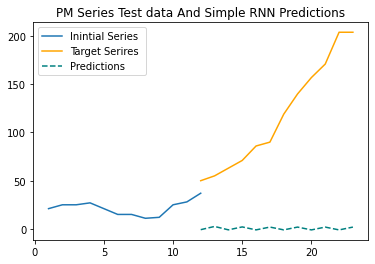

In [34]:
predict_and_plot(test_X_init,test_y,model,'PM Series Test data And Simple RNN Predictions')

Epoch 1/120
7/7 [==============================] - 1s 3ms/step - loss: 42702.6250
Epoch 2/120
7/7 [==============================] - 0s 3ms/step - loss: 42636.3242
Epoch 3/120
7/7 [==============================] - 0s 4ms/step - loss: 42570.8086
Epoch 4/120
7/7 [==============================] - 0s 3ms/step - loss: 42503.8633
Epoch 5/120
7/7 [==============================] - 0s 3ms/step - loss: 42436.8906
Epoch 6/120
7/7 [==============================] - 0s 4ms/step - loss: 42360.0469
Epoch 7/120
7/7 [==============================] - 0s 4ms/step - loss: 42248.0352
Epoch 8/120
7/7 [==============================] - 0s 5ms/step - loss: 42073.6602
Epoch 9/120
7/7 [==============================] - 0s 4ms/step - loss: 41999.2656
Epoch 10/120
7/7 [==============================] - 0s 4ms/step - loss: 41901.7539
Epoch 11/120
7/7 [==============================] - 0s 4ms/step - loss: 41747.2266
Epoch 12/120
7/7 [==============================] - 0s 4ms/step - loss: 41589.0703
Epoch 13/120


7/7 [==============================] - 0s 2ms/step - loss: 36269.2422
Epoch 100/120
7/7 [==============================] - 0s 3ms/step - loss: 36220.9531
Epoch 101/120
7/7 [==============================] - 0s 2ms/step - loss: 36168.7969
Epoch 102/120
7/7 [==============================] - 0s 3ms/step - loss: 36117.5000
Epoch 103/120
7/7 [==============================] - 0s 3ms/step - loss: 36067.9180
Epoch 104/120
7/7 [==============================] - 0s 3ms/step - loss: 36015.5742
Epoch 105/120
7/7 [==============================] - 0s 3ms/step - loss: 35965.6016
Epoch 106/120
7/7 [==============================] - 0s 3ms/step - loss: 35915.4688
Epoch 107/120
7/7 [==============================] - 0s 4ms/step - loss: 35865.5039
Epoch 108/120
7/7 [==============================] - 0s 2ms/step - loss: 35814.6016
Epoch 109/120
7/7 [==============================] - 0s 3ms/step - loss: 35763.4492
Epoch 110/120
7/7 [==============================] - 0s 3ms/step - loss: 35714.2383
Epoch 

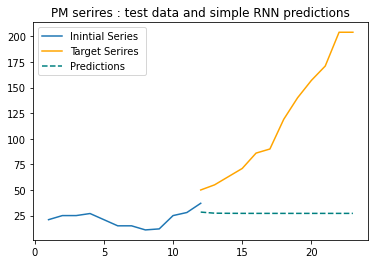

In [35]:
model=fit_SimpleRNN(train_X,train_y,cell_units=30,epochs=120)
predict_and_plot(test_X_init,test_y,model,'PM serires : test data and simple RNN predictions')

In [36]:
def fit_LSTM(train_X,train_y,cell_units,epochs):
    model=Sequential()
    model.add(LSTM(cell_units,input_shape=(train_X.shape[1],1)))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.fit(train_X,train_y,epochs=epochs,batch_size=64,verbose=0)
    
    return model